In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calendar
import math
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
searches_file = ('searches.tsv')
searches = pd.read_csv(searches_file, sep="\t")
contacts_file = ("contacts.tsv")
contacts = pd.read_csv(contacts_file, sep='\t')

searches_file_v2 = ("searches_v2.tsv")
searches_v2 = pd.read_csv(searches_file_v2, sep='\t')
contacts_file_v2 = ("contacts_v2.tsv")
contacts_v2 = pd.read_csv(contacts_file_v2, sep='\t')

searches_contacts_file = ("searches_contacts_joined.tsv")
searches_contacts = pd.read_csv(searches_contacts_file, sep='\t')

/tmp/ipykernel_37/2683547487.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_input.dropna(subset=['n_nights'], inplace=True)
/tmp/ipykernel_37/2683547487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_input.dropna(subset=['n_guests_max'], inplace=True)


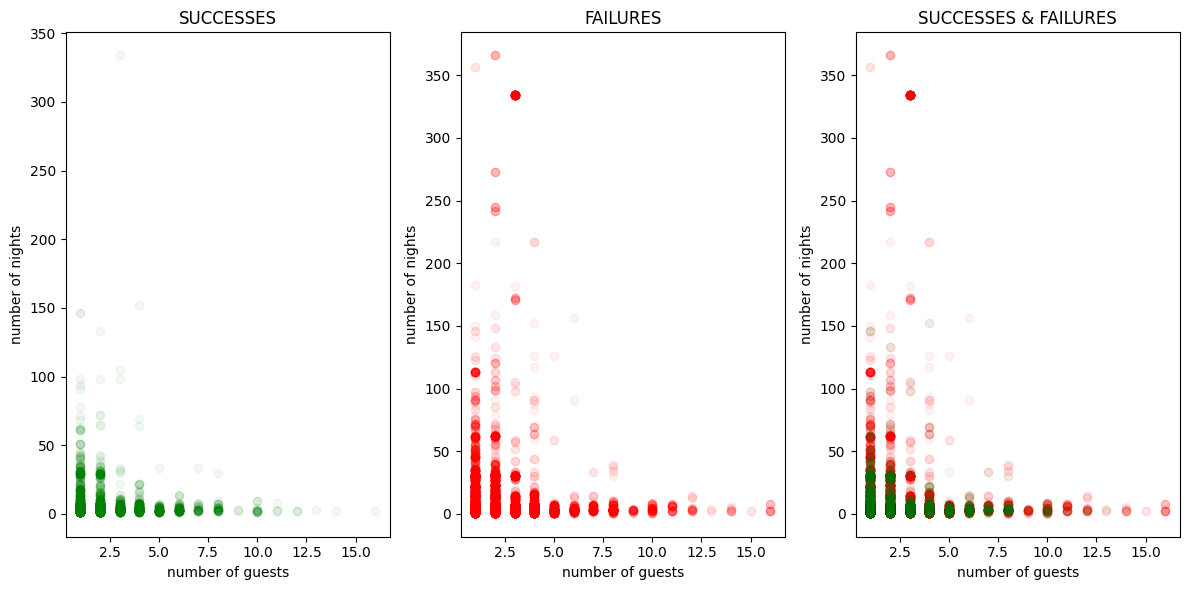

In [ ]:
search_input = searches_contacts[['n_nights', 'n_guests_max', 'ts_booking_at_dt']]
for i in range(len(search_input)):
    if pd.isna(search_input.loc[i, 'ts_booking_at_dt']):
        search_input.loc[i, 'ts_booking_at_dt'] = 0
    else:
        search_input.loc[i, 'ts_booking_at_dt'] = 1

search_input.dropna(subset=['n_nights'], inplace=True)
search_input.dropna(subset=['n_guests_max'], inplace=True)

no = search_input[search_input['ts_booking_at_dt'] == 0]
yes = search_input[search_input['ts_booking_at_dt'] == 1]

plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title('SUCCESSES')
plt.xlabel('number of guests')
plt.ylabel('number of nights')
plt.scatter(yes['n_guests_max'], yes['n_nights'], color = 'green', alpha=0.05)

plt.subplot(1,3,2)
plt.title('FAILURES')
plt.xlabel('number of guests')
plt.ylabel('number of nights')
plt.scatter(no['n_guests_max'], no['n_nights'], color = 'red', alpha=0.05)

plt.subplot(1,3,3)
plt.title('SUCCESSES & FAILURES')
plt.xlabel('number of guests')
plt.ylabel('number of nights')
plt.scatter(no['n_guests_max'], no['n_nights'], color = 'red', alpha=0.05)
plt.scatter(yes['n_guests_max'], yes['n_nights'], color = 'green', alpha=0.05)

plt.tight_layout()


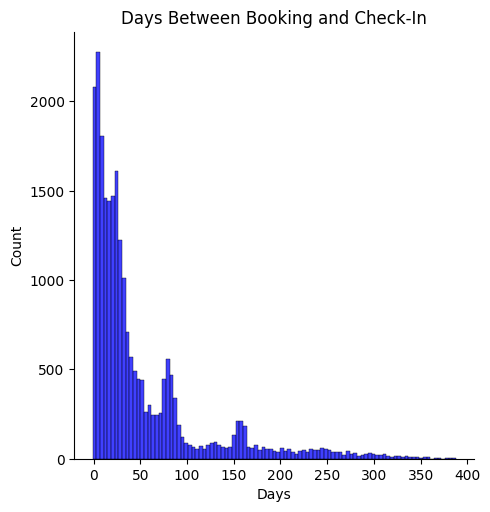

In [ ]:
searches['ds_checkin'] = pd.to_datetime(searches['ds_checkin'])
searches['ds_checkout'] = pd.to_datetime(searches['ds_checkout'])
searches['ds'] = pd.to_datetime(searches['ds'])

dates = searches[['ds_checkin', 'ds_checkout', 'ds']].dropna()
dates['duration'] = dates['ds_checkout'] - dates['ds_checkin']
dates['Days'] = dates['ds_checkin'] - dates['ds']

lead_time = dates['Days'] / np.timedelta64(1, 'D')
lead_time = lead_time[lead_time < 400]
sns.displot(x=lead_time, color='blue')
plt.title('Days Between Booking and Check-In')
plt.show()

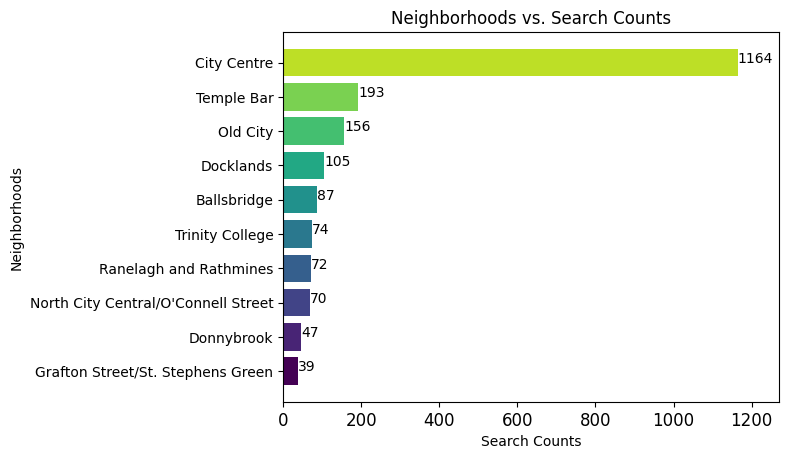

In [ ]:
n_count = dict()
neighborhoods = searches[['filter_neighborhoods']].dropna()

for index,row in neighborhoods.iterrows():
    n = row['filter_neighborhoods']
    n = n.strip(',')
    n = n.split(',')
    for i in n:
        if i in n_count:
            n_count[i] += 1
        else:
            n_count[i] = 1


n_df = pd.DataFrame({
    "Location": n_count.keys(),
    "Searches" : n_count.values()
})

n_df = n_df.nlargest(10,["Searches"]).sort_values(by="Searches")
location = n_df["Location"].tolist()
count = n_df["Searches"].tolist()

colors = plt.get_cmap('viridis')
amount = len(count)
x = np.arange(amount)

for index, value in enumerate(count):
    plt.text(value, index,
             str(value))

plt.barh(location, count, tick_label=location, color=colors(x / amount))
plt.xticks(fontsize=12)
plt.title("Neighborhoods vs. Search Counts")
plt.xlabel("Search Counts")
plt.ylabel("Neighborhoods")
plt.xlim(0, 1270)
plt.show()

In [ ]:
prices = searches_v2[["filter_price_min","filter_price_max"]]
prices.fillna("NULL",inplace=True)
def categorize_price(x):
    if x == "NULL":
        return "NULL"
    elif x >= 1073741823:
        return "NULL"
    elif x < 50:
        return "0-49"
    elif x < 100:
        return "50-99"
    elif x < 150:
        return "100-149"
    elif x < 200:
        return "150-199"
    elif x < 250:
        return "200-249"
    elif x < 300:
        return "250-299"
    elif x < 400:
        return "300-399"
    elif x >= 400:
        return "400+"
prices["Min_Category"] = prices["filter_price_min"].apply(categorize_price)
prices["Max_Category"] = prices["filter_price_max"].apply(categorize_price)
prices["One"] = [1 for _ in prices["Min_Category"]]

sns.heatmap(pd.pivot_table(prices, values='One', index='Max_Category', columns='Min_Category',
                          aggfunc='sum'),annot=True)
# prices.pivot(index='Min_Category', columns='Max_Category',values="One")

In [ ]:
prices

,filter_price_min,filter_price_max
0,0.0,67.0
1,0.0,67.0
2,NULL,NULL
3,NULL,NULL
4,NULL,NULL
...,...,...
35732,0.0,100.0
35733,NULL,NULL
35734,NULL,NULL
35735,0.0,485.0


<AxesSubplot: title={'center': 'DAY VS. MONTH: # OF CHECK INS'}, xlabel='month', ylabel='day'>

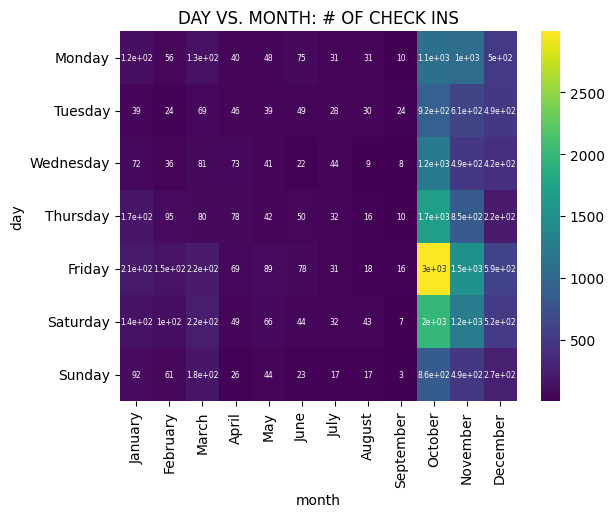

In [ ]:
def check_weekday_or_weekend(date):
    given_date = datetime.datetime.strptime(date, '%Y-%m-%d')
    day_of_week = (given_date.weekday() + 1) % 7 

    if day_of_week == 0:
        day_word = 'Sunday'
    elif day_of_week == 1:
        day_word = 'Monday'
    elif day_of_week == 2:
        day_word = 'Tuesday'
    elif day_of_week == 3:
        day_word = 'Wednesday'
    elif day_of_week == 4:
        day_word = 'Thursday'
    elif day_of_week == 5:
        day_word = 'Friday'
    elif day_of_week == 6:
        day_word = 'Saturday'

    return day_word

def check_month(date):
    date = date.split('-')
    month = int(date[1])
    return calendar.month_name[month]


days_dict = dict()

for i in searches_v2['ds_checkin_date'].dropna():
    day = check_weekday_or_weekend(i)
    month = check_month(i)
    if (day,month) in days_dict:
        days_dict[(day,month)] += 1
    else:
        days_dict[(day,month)] = 1

days_data = pd.DataFrame(list(days_dict.items()), columns=['(x, y)', 'count'])
days_data[['day', 'month']] = pd.DataFrame(days_data['(x, y)'].tolist(), index=days_data.index)
days_data.drop('(x, y)', axis=1, inplace=True)

days_data['day'] = pd.Categorical(days_data['day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
days_data['month'] = pd.Categorical(days_data['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

plt.title('DAY VS. MONTH: # OF CHECK INS')
grid = days_data.pivot(index='day', columns='month', values='count')
sns.heatmap(grid, annot=True, annot_kws={'size': 5.5}, cmap='viridis')

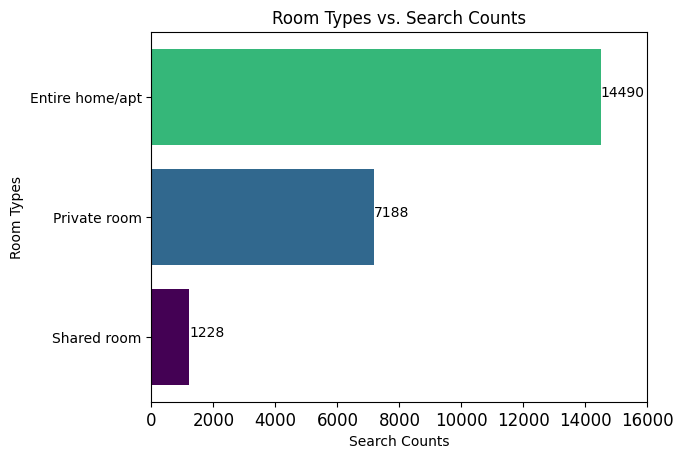

In [ ]:
n_count = dict()
rooms = searches[['filter_room_types']].dropna()

for index,row in rooms.iterrows():
    n = row['filter_room_types']
    n = n.strip(',')
    n = n.split(',')
    for i in n:
        if i in n_count:
            n_count[i] += 1
        else:
            n_count[i] = 1

n_df = pd.DataFrame({
    "Location": n_count.keys(),
    "Searches" : n_count.values()
})

n_df = n_df.nlargest(10,["Searches"]).sort_values(by="Searches")
location = n_df["Location"].tolist()
count = n_df["Searches"].tolist()

colors = plt.get_cmap('viridis')
amount = len(count)
x = np.arange(amount)

plt.barh(location, count, tick_label=location, color=colors(x / amount))

for index, value in enumerate(count):
    plt.text(value, index,
             str(value))

plt.xticks(fontsize=12)
plt.title("Room Types vs. Search Counts")
plt.xlabel("Search Counts")
plt.ylabel("Room Types")
plt.xlim(0, 16000)
plt.show()


In [ ]:
display(searches.describe())

,ds,ds_checkin,ds_checkout,n_searches,n_nights,n_guests_min,n_guests_max,filter_price_min,filter_price_max
count,35737,23888,23888,35737.000000,23888.000000,35737.000000,35737.000000,13322.000000,1.332200e+04
mean,2014-10-07 14:32:34.478551552,2014-11-27 22:42:10.609511168,2014-12-05 14:50:57.468184832,9.206565,7.672765,1.742955,2.105857,8.470200,9.019063e+07
min,2014-10-01 00:00:00,2014-10-01 00:00:00,2014-10-02 00:00:00,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000e+00
25%,2014-10-04 00:00:00,2014-10-17 00:00:00,2014-10-23 00:00:00,1.000000,2.000000,1.000000,1.000000,0.000000,8.600000e+01
50%,2014-10-08 00:00:00,2014-11-03 00:00:00,2014-11-09 00:00:00,4.000000,3.000000,1.000000,2.000000,0.000000,1.390000e+02
75%,2014-10-11 00:00:00,2014-12-13 00:00:00,2014-12-24 00:00:00,10.000000,5.000000,2.000000,2.000000,0.000000,3.010000e+02
max,2014-10-14 00:00:00,2016-06-02 00:00:00,2016-08-17 00:00:00,448.000000,399.000000,16.000000,16.000000,1250.000000,1.073742e+09
std,NaN,NaN,NaN,17.348746,21.557614,1.460440,1.817358,53.987679,2.978482e+08


In [ ]:
display(searches.skew(axis=0, numeric_only=True, skipna=True))

n_searches           7.509258
n_nights             9.942364
n_guests_min         3.583798
n_guests_max         3.148548
filter_price_min    11.087745
filter_price_max     2.999833
dtype: float64

/tmp/ipykernel_37/702654108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_prices['Price'] = max_prices['filter_price_max']


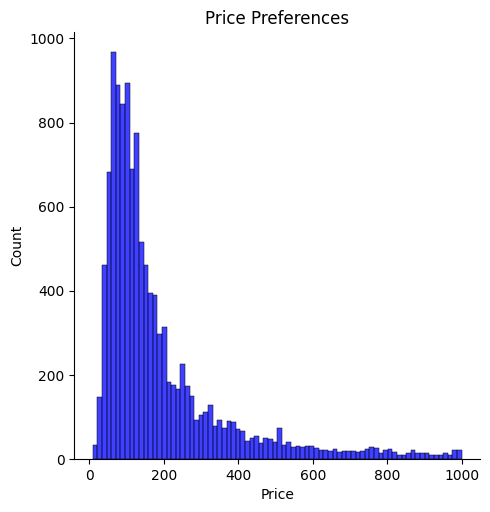

In [ ]:
max_prices = searches[searches['filter_price_max'] < 1000]
max_prices['Price'] = max_prices['filter_price_max']
sns.displot(x=max_prices['Price'], color='blue')
plt.title('Price Preferences')
plt.show()

In [ ]:
#Convert date columns to datetime data type 
contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
contacts['accepted'] = np.where(np.isnan(contacts['ts_accepted_at']), False, True)

contacts['length_stay'] = contacts['ds_checkout'] - contacts['ds_checkin']

#Understand dataset
display(contacts.dtypes)
display(contacts.describe())

id_guest                   object
id_host                    object
id_listing                 object
ts_contact_at      datetime64[ns]
ts_reply_at        datetime64[ns]
ts_accepted_at     datetime64[ns]
ts_booking_at      datetime64[ns]
ds_checkin         datetime64[ns]
ds_checkout        datetime64[ns]
n_guests                    int64
n_messages                  int64
accepted                     bool
length_stay       timedelta64[ns]
dtype: object

,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,n_messages,length_stay
count,7823,7219,3627,2174,7823,7823,7823.000000,7823.000000,7823
mean,2014-10-10 11:59:33.640802816,2014-10-10 22:42:36.511982336,2014-10-11 14:07:07.993382912,2014-10-13 07:54:43.307267840,2014-11-16 09:47:00.452511744,2014-11-22 05:12:33.317141760,2.422600,6.319954,5 days 19:25:32.864629937
min,2014-03-04 11:08:13,2014-04-18 09:39:06,2014-05-21 16:51:54,2014-05-21 16:51:54,2014-10-01 00:00:00,2014-10-02 00:00:00,1.000000,1.000000,1 days 00:00:00
25%,2014-10-03 16:28:52,2014-10-03 23:07:32,2014-10-04 13:45:13,2014-10-05 13:53:46,2014-10-15 00:00:00,2014-10-19 00:00:00,1.000000,2.000000,2 days 00:00:00
50%,2014-10-08 17:34:36,2014-10-09 00:16:21,2014-10-09 13:46:50,2014-10-10 11:15:13,2014-10-31 00:00:00,2014-11-06 00:00:00,2.000000,4.000000,3 days 00:00:00
75%,2014-10-13 21:28:51.500000,2014-10-14 10:00:04.500000,2014-10-14 16:28:27.500000,2014-10-15 13:16:17.249999872,2014-11-22 00:00:00,2014-11-30 00:00:00,3.000000,8.000000,5 days 00:00:00
max,2015-02-02 08:45:18,2015-02-02 23:18:25,2015-02-03 14:16:42,2015-01-21 16:16:29,2015-10-24 00:00:00,2015-12-01 00:00:00,16.000000,102.000000,334 days 00:00:00
std,NaN,NaN,NaN,NaN,NaN,NaN,1.617347,6.472827,14 days 23:45:24.447710564


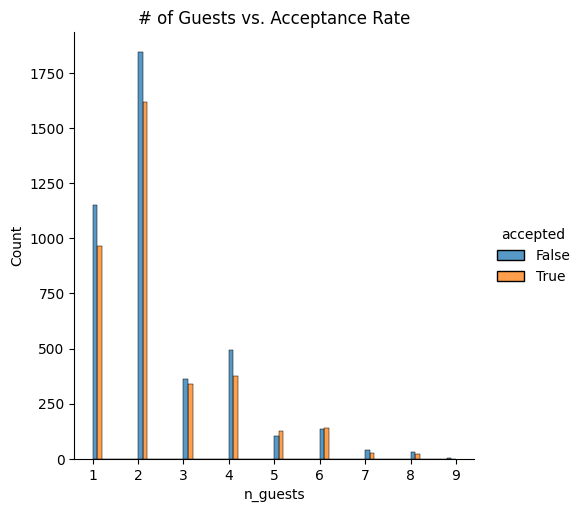

In [ ]:
sns.displot(contacts[contacts['n_guests'] < 10], x='n_guests', hue='accepted', multiple='dodge')
plt.title('# of Guests vs. Acceptance Rate')
plt.show()

In [ ]:
merged_datasets = contacts.merge(searches_v2, left_on='id_guest', right_on='id_user')

In [ ]:
#Classify dataset based on filter_price_max

def label_price (row):
    if (row['filter_price_max'] >= 0) & (row['filter_price_max'] < 100):
        return '0-100'
    
    elif (row['filter_price_max'] >= 100) & (row['filter_price_max'] < 200):
        return '100-200'

    elif (row['filter_price_max'] >= 200) & (row['filter_price_max'] < 300):
        return '200-300'
    
    elif (row['filter_price_max'] >= 300) & (row['filter_price_max'] < 400):
        return '300-400'

    elif (row['filter_price_max'] >= 400) & (row['filter_price_max'] < 500):
        return '400-500'
    
    elif (row['filter_price_max'] >= 500) & (row['filter_price_max'] < 600):
        return '500-600'
    
    else:
        return '600+'

merged_datasets['classification_max_price'] = merged_datasets.apply(lambda row: label_price(row), axis=1)

merged_datasets.groupby(['ds','ds_checkin','classification_max_price'],as_index=False).agg({'accepted': 'mean','id_guest':'count'})

,ds,ds_checkin,classification_max_price,accepted,id_guest
0,2014-10-01,2014-10-01,0-100,0.500000,2
1,2014-10-01,2014-10-01,100-200,0.272727,11
2,2014-10-01,2014-10-01,200-300,0.000000,4
3,2014-10-01,2014-10-01,500-600,0.000000,4
4,2014-10-01,2014-10-01,600+,0.260870,23
...,...,...,...,...,...
3473,2014-10-14,2015-07-19,600+,1.000000,2
3474,2014-10-14,2015-08-01,600+,0.000000,1
3475,2014-10-14,2015-09-15,600+,0.333333,6
3476,2014-10-14,2015-09-24,0-100,0.000000,2


In [ ]:
DeepnoteChart(merged_datasets, """{"mark":{"type":"bar","tooltip":true},"width":"container","config":{"customFormatTypes":true},"height":"container","$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{"x":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear"},"format":{"type":"default","decimals":null}},"y":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear"},"format":{"type":"default","decimals":null}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear"},"format":{"type":"default","decimals":null}}}}""")

In [ ]:
merged_datasets

,id_guest,id_host,id_listing,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,...,n_nights,n_guests_min,n_guests_max,origin_country,filter_price_min,filter_price_max,filter_room_types,filter_neighborhoods,Price-Range,classification_max_price
0,000dfad9-459b-4f0b-8310-3d6ab34e4f57,13bb24b8-d432-43a2-9755-5ea11b43bb69,21d2b1a2-fdc3-4b4c-a1f0-0eaf0cc02370,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-13,2014-10-15,2,...,2.0,2,2,CA,0.0,130.0,Entire home/apt,NaN,0-130,100-200
1,00197051-c6cb-4c3a-99e9-86615b819874,46aa3897-9c00-4d76-ac66-a307593d0675,fb5ed09a-9848-4f2c-b2ef-34deb62164fb,2014-11-04 09:10:03,2014-11-04 09:45:50,2014-11-04 09:45:50,2014-11-04 12:20:46,2014-11-27,2014-11-30,1,...,3.0,1,1,DK,0.0,336.0,"Entire home/apt,Private room,Private room",NaN,0-336,300-400
2,0027538e-aa9e-4a02-8979-b8397e5d4cba,6bbb88ca-db66-48c5-9c4b-862f7706284a,d3871da6-8012-4dc4-b508-c91f2c10c297,2014-10-10 12:02:50,2014-10-10 15:07:01,NaT,NaT,2014-10-17,2014-10-19,2,...,2.0,2,2,CY,0.0,1258.0,"Entire home/apt,Entire home/apt,Private room,P...",NaN,0-1258,600+
3,0027538e-aa9e-4a02-8979-b8397e5d4cba,6bbb88ca-db66-48c5-9c4b-862f7706284a,d3871da6-8012-4dc4-b508-c91f2c10c297,2014-10-10 12:02:50,2014-10-10 15:07:01,NaT,NaT,2014-10-17,2014-10-19,2,...,2.0,2,2,CY,0.0,214.0,Entire home/apt,NaN,0-214,200-300
4,0027538e-aa9e-4a02-8979-b8397e5d4cba,8772bc85-a9b7-4d85-a52d-41f3620c2912,0d9b5583-8053-4b67-adfe-8c29eb12efed,2014-10-10 15:23:53,NaT,NaT,NaT,2014-10-17,2014-10-19,2,...,2.0,2,2,CY,0.0,1258.0,"Entire home/apt,Entire home/apt,Private room,P...",NaN,0-1258,600+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28531,ffe366f0-6ab6-4e94-818a-c69c125fed3c,f86bc9ab-e199-4254-8609-fd67d6aaed42,28caf371-6d1d-4e06-aaf1-e660966ac7a1,2014-10-07 21:30:31,2014-10-08 19:04:43,NaT,NaT,2014-10-17,2014-10-20,2,...,3.0,2,2,IT,0.0,105.0,NaN,NaN,0-105,100-200
28532,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,30.0,1,2,AR,NaN,NaN,NaN,NaN,-,600+
28533,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,6.0,2,2,AR,0.0,170.0,NaN,NaN,0-170,100-200
28534,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,6.0,2,2,AR,0.0,34.0,NaN,NaN,0-34,0-100


In [ ]:
merged_datasets

,id_guest,id_host,id_listing,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,...,n_nights,n_guests_min,n_guests_max,origin_country,filter_price_min,filter_price_max,filter_room_types,filter_neighborhoods,Price-Range,classification_max_price
0,000dfad9-459b-4f0b-8310-3d6ab34e4f57,13bb24b8-d432-43a2-9755-5ea11b43bb69,21d2b1a2-fdc3-4b4c-a1f0-0eaf0cc02370,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-13,2014-10-15,2,...,2.0,2,2,CA,0.0,130.0,Entire home/apt,NaN,0-130,100-200
1,00197051-c6cb-4c3a-99e9-86615b819874,46aa3897-9c00-4d76-ac66-a307593d0675,fb5ed09a-9848-4f2c-b2ef-34deb62164fb,2014-11-04 09:10:03,2014-11-04 09:45:50,2014-11-04 09:45:50,2014-11-04 12:20:46,2014-11-27,2014-11-30,1,...,3.0,1,1,DK,0.0,336.0,"Entire home/apt,Private room,Private room",NaN,0-336,300-400
2,0027538e-aa9e-4a02-8979-b8397e5d4cba,6bbb88ca-db66-48c5-9c4b-862f7706284a,d3871da6-8012-4dc4-b508-c91f2c10c297,2014-10-10 12:02:50,2014-10-10 15:07:01,NaT,NaT,2014-10-17,2014-10-19,2,...,2.0,2,2,CY,0.0,1258.0,"Entire home/apt,Entire home/apt,Private room,P...",NaN,0-1258,600+
3,0027538e-aa9e-4a02-8979-b8397e5d4cba,6bbb88ca-db66-48c5-9c4b-862f7706284a,d3871da6-8012-4dc4-b508-c91f2c10c297,2014-10-10 12:02:50,2014-10-10 15:07:01,NaT,NaT,2014-10-17,2014-10-19,2,...,2.0,2,2,CY,0.0,214.0,Entire home/apt,NaN,0-214,200-300
4,0027538e-aa9e-4a02-8979-b8397e5d4cba,8772bc85-a9b7-4d85-a52d-41f3620c2912,0d9b5583-8053-4b67-adfe-8c29eb12efed,2014-10-10 15:23:53,NaT,NaT,NaT,2014-10-17,2014-10-19,2,...,2.0,2,2,CY,0.0,1258.0,"Entire home/apt,Entire home/apt,Private room,P...",NaN,0-1258,600+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28531,ffe366f0-6ab6-4e94-818a-c69c125fed3c,f86bc9ab-e199-4254-8609-fd67d6aaed42,28caf371-6d1d-4e06-aaf1-e660966ac7a1,2014-10-07 21:30:31,2014-10-08 19:04:43,NaT,NaT,2014-10-17,2014-10-20,2,...,3.0,2,2,IT,0.0,105.0,NaN,NaN,0-105,100-200
28532,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,30.0,1,2,AR,NaN,NaN,NaN,NaN,-,600+
28533,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,6.0,2,2,AR,0.0,170.0,NaN,NaN,0-170,100-200
28534,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,6.0,2,2,AR,0.0,34.0,NaN,NaN,0-34,0-100


In [ ]:
#Find the acceptance rate by country
merged_datasets["accepted"]
dataset_country = merged_datasets[['origin_country', 'accepted']]

#Find acceptance count by country and accepted
accepted_count = dataset_country.groupby(['origin_country', 'accepted']).agg({'origin_country':'count'})
accepted_count.columns = ['count_accepted']

#Find acceptance count by country
country_count = dataset_country.groupby(['origin_country']).agg({'origin_country':'count'})
country_count.columns = ['count_country']

#Merge datasets for easier manipulation 
acceptance_country = pd.merge(dataset_country, accepted_count,  how='left', on=['origin_country','accepted']) #Merge accepted count
acceptance_country = acceptance_country.drop_duplicates()

acceptance_country = pd.merge(acceptance_country, country_count, how='left', on=['origin_country']) #Merge total country count
acceptance_country = acceptance_country.sort_values(['count_country', 'accepted'], ascending = [False, True])
acceptance_country = acceptance_country[acceptance_country['count_country'] >= 100] #100 is used so there is a good amount of data to make assumptions
acceptance_country = acceptance_country[acceptance_country['accepted'] == True]

#Divide count_accepted column by count_country column to find acceptance rate by country
acceptance_country['acceptance_rate'] = acceptance_country['count_accepted']/acceptance_country['count_country']
acceptance_country.sort_values(['acceptance_rate'], ascending = True)

,origin_country,accepted,count_accepted,count_country,acceptance_rate
73,IN,True,138,874,0.157895
55,HR,True,159,530,0.300000
72,AT,True,83,239,0.347280
54,RU,True,83,239,0.347280
11,IT,True,1183,3137,0.377112
100,AE,True,59,154,0.383117
0,CA,True,407,993,0.409869
13,IE,True,1217,2951,0.412403
24,ES,True,794,1914,0.414838
49,RO,True,50,118,0.423729


In [ ]:
merged_datasets

,id_guest,id_host,id_listing,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,...,n_searches,n_nights,n_guests_min,n_guests_max,origin_country,filter_price_min,filter_price_max,filter_room_types,filter_neighborhoods,Price-Range
0,000dfad9-459b-4f0b-8310-3d6ab34e4f57,13bb24b8-d432-43a2-9755-5ea11b43bb69,21d2b1a2-fdc3-4b4c-a1f0-0eaf0cc02370,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-04 16:26:28,2014-10-13,2014-10-15,2,...,6,2.0,2,2,CA,0.0,130.0,Entire home/apt,NaN,0-130
1,00197051-c6cb-4c3a-99e9-86615b819874,46aa3897-9c00-4d76-ac66-a307593d0675,fb5ed09a-9848-4f2c-b2ef-34deb62164fb,2014-11-04 09:10:03,2014-11-04 09:45:50,2014-11-04 09:45:50,2014-11-04 12:20:46,2014-11-27,2014-11-30,1,...,13,3.0,1,1,DK,0.0,336.0,"Entire home/apt,Private room,Private room",NaN,0-336
2,0027538e-aa9e-4a02-8979-b8397e5d4cba,6bbb88ca-db66-48c5-9c4b-862f7706284a,d3871da6-8012-4dc4-b508-c91f2c10c297,2014-10-10 12:02:50,2014-10-10 15:07:01,NaT,NaT,2014-10-17,2014-10-19,2,...,21,2.0,2,2,CY,0.0,1258.0,"Entire home/apt,Entire home/apt,Private room,P...",NaN,0-1258
3,0027538e-aa9e-4a02-8979-b8397e5d4cba,6bbb88ca-db66-48c5-9c4b-862f7706284a,d3871da6-8012-4dc4-b508-c91f2c10c297,2014-10-10 12:02:50,2014-10-10 15:07:01,NaT,NaT,2014-10-17,2014-10-19,2,...,44,2.0,2,2,CY,0.0,214.0,Entire home/apt,NaN,0-214
4,0027538e-aa9e-4a02-8979-b8397e5d4cba,8772bc85-a9b7-4d85-a52d-41f3620c2912,0d9b5583-8053-4b67-adfe-8c29eb12efed,2014-10-10 15:23:53,NaT,NaT,NaT,2014-10-17,2014-10-19,2,...,21,2.0,2,2,CY,0.0,1258.0,"Entire home/apt,Entire home/apt,Private room,P...",NaN,0-1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28531,ffe366f0-6ab6-4e94-818a-c69c125fed3c,f86bc9ab-e199-4254-8609-fd67d6aaed42,28caf371-6d1d-4e06-aaf1-e660966ac7a1,2014-10-07 21:30:31,2014-10-08 19:04:43,NaT,NaT,2014-10-17,2014-10-20,2,...,10,3.0,2,2,IT,0.0,105.0,NaN,NaN,0-105
28532,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,4,30.0,1,2,AR,NaN,NaN,NaN,NaN,-
28533,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,3,6.0,2,2,AR,0.0,170.0,NaN,NaN,0-170
28534,fffea166-9432-43a7-8b1b-09d6f30c1c07,6d656267-642e-4972-bdec-a35d82b84ebb,90dddef6-23ef-4df3-b454-8fd3d0e8cade,2014-10-08 00:05:05,2014-10-12 20:58:12,NaT,NaT,2014-11-11,2014-11-18,2,...,2,6.0,2,2,AR,0.0,34.0,NaN,NaN,0-34


Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


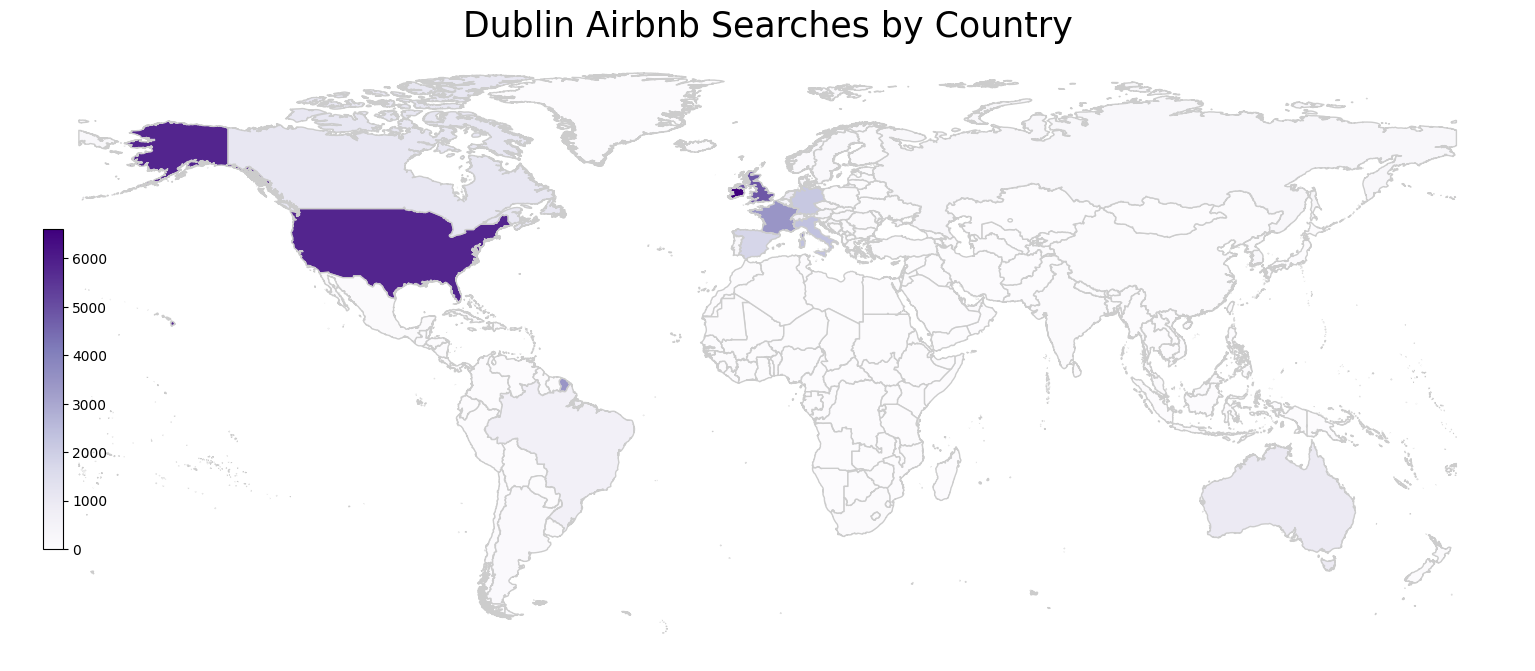

In [ ]:
import country_converter as coco

countries = searches[['origin_country']]
countries_dict = {}

for index,row in countries.iterrows():
    country = row['origin_country']
    if country in countries_dict:
        countries_dict[country] += 1
    else:
        countries_dict[country] = 1

country_keys = countries_dict.keys()
country_values = countries_dict.values()
heatmap_data = {
    'origin_country': country_keys,
    'Count': country_values
}
countries_df = pd.DataFrame(heatmap_data)

SHAPEFILE = '/work/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)
iso3_codes = geo_df['country'].to_list()
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
geo_df['iso2_code'] = iso2_codes_list
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)
merged_df = pd.merge(left=geo_df, right=countries_df, how='left', left_on='iso2_code', right_on='origin_country')
merged_df = merged_df.drop(['origin_country'], axis=1)
merged_df['Count'] = merged_df['Count'].fillna(0)
vmin = merged_df['Count'].min()
vmax = merged_df['Count'].max()
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
merged_df.plot(column='Count', ax=ax, edgecolor='0.8', linewidth=1, cmap='Purples')
ax.set_title('Dublin Airbnb Searches by Country', fontdict={'fontsize': '25', 'fontweight': '3'})
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Purples')
sm._A = []
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


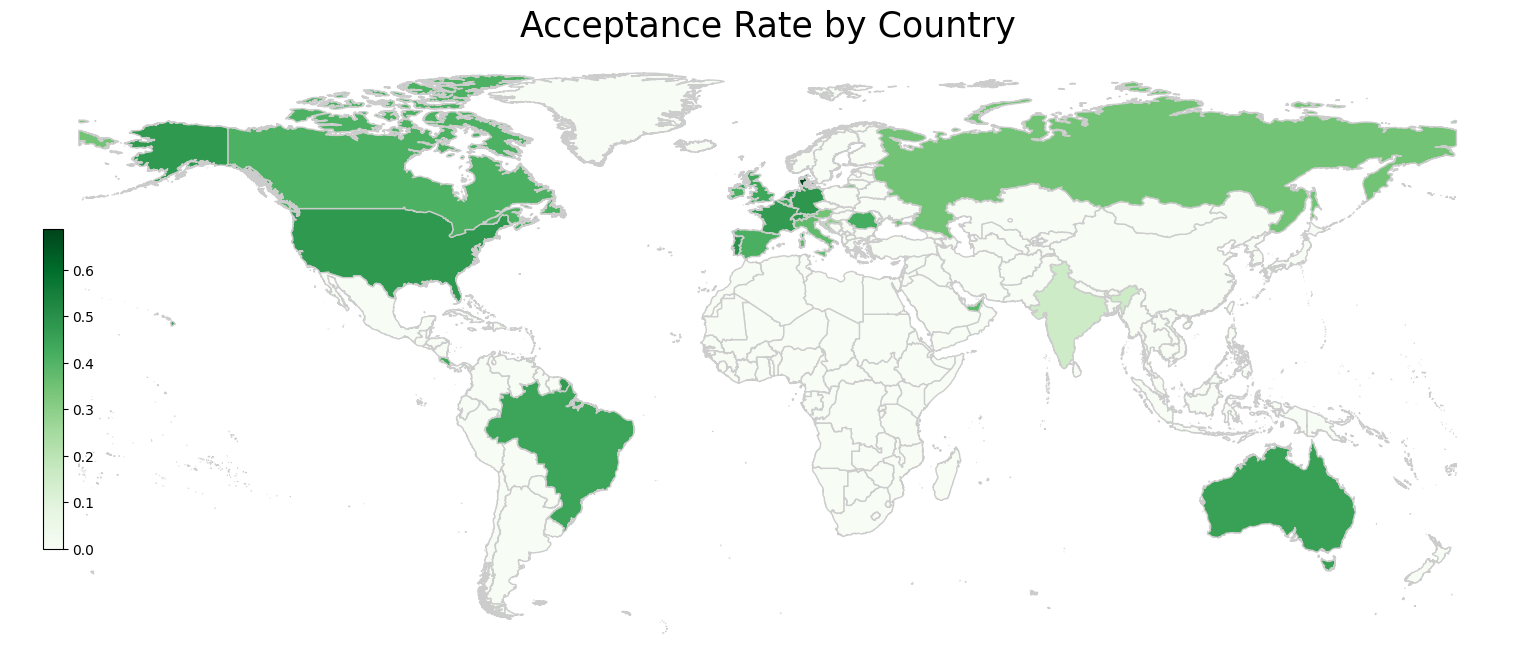

In [ ]:
countries_df = acceptance_country[['origin_country', 'acceptance_rate']]

SHAPEFILE = '/work/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)
iso3_codes = geo_df['country'].to_list()
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
geo_df['iso2_code'] = iso2_codes_list
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)
merged_df = pd.merge(left=geo_df, right=countries_df, how='left', left_on='iso2_code', right_on='origin_country')
merged_df = merged_df.drop(['origin_country'], axis=1)
merged_df['acceptance_rate'] = merged_df['acceptance_rate'].fillna(0)
vmin = merged_df['acceptance_rate'].min()
vmax = merged_df['acceptance_rate'].max()
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
merged_df.plot(column='acceptance_rate', ax=ax, edgecolor='0.8', linewidth=1, cmap='Greens')
ax.set_title('Acceptance Rate by Country', fontdict={'fontsize': '25', 'fontweight': '3'})
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Greens')
sm._A = []
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

label_encoder = LabelEncoder()
features = contacts[['id_host', 'id_listing', 'ts_contact_at', 'ds_checkin', 'ds_checkout', 'n_guests', 'n_messages']]
targets = contacts['ts_booking_at'].notnull().astype(int)
features['id_host'] = label_encoder.fit_transform(features['id_host'])
features['id_listing'] = label_encoder.fit_transform(features['id_listing'])

features['ts_contact_at'] = pd.to_datetime(features['ts_contact_at'])
features['ts_contact_at_year'] = features['ts_contact_at'].dt.year
features['ts_contact_at_month'] = features['ts_contact_at'].dt.month
features['ts_contact_at_day'] = features['ts_contact_at'].dt.day
features['ts_contact_at_hour'] = features['ts_contact_at'].dt.hour
features['ts_contact_at_minute'] = features['ts_contact_at'].dt.minute
features['ts_contact_at_day_of_week'] = features['ts_contact_at'].dt.day_of_week
features['ts_contact_at_quarter'] = features['ts_contact_at'].dt.quarter
features.drop(columns=['ts_contact_at'], inplace=True)

features['ds_checkin'] = pd.to_datetime(features['ds_checkin'])
features['ds_checkin_year'] = features['ds_checkin'].dt.year
features['ds_checkin_month'] = features['ds_checkin'].dt.month
features['ds_checkin_day'] = features['ds_checkin'].dt.day
features['ds_checkin_day_of_week'] = features['ds_checkin'].dt.day_of_week
features['ds_checkin_quarter'] = features['ds_checkin'].dt.quarter
features.drop(columns=['ds_checkin'], inplace=True)

features['ds_checkout'] = pd.to_datetime(features['ds_checkout'])
features['ds_checkout_year'] = features['ds_checkout'].dt.year
features['ds_checkout_month'] = features['ds_checkout'].dt.month
features['ds_checkout_day'] = features['ds_checkout'].dt.day
features['ds_checkout_day_of_week'] = features['ds_checkout'].dt.day_of_week
features['ds_checkout_quarter'] = features['ds_checkout'].dt.quarter
features.drop(columns=['ds_checkout'], inplace=True)

X_tr, X_te, y_tr, y_te = train_test_split(features, targets, test_size=0.2, random_state=0)
X_tr.fillna(-1, inplace=True)
X_te.fillna(-1, inplace=True)

scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_te_scaled = scaler.fit_transform(X_te)

model = LogisticRegression()
model.fit(X_tr_scaled, y_tr)

y_pred = model.predict(X_te_scaled)

accuracy = accuracy_score(y_te, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_te, y_pred))

TN, FP, FN, TP = confusion_matrix(y_te, y_pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)
accuracy =  (TP + TN) / (TP + FP + TN + FN)

print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

/tmp/ipykernel_37/1907951276.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['id_host'] = label_encoder.fit_transform(features['id_host'])
/tmp/ipykernel_37/1907951276.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['id_listing'] = label_encoder.fit_transform(features['id_listing'])
/tmp/ipykernel_37/1907951276.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6cced6a8-fe40-40d7-b88b-a3eb124108df' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>